Regularization
1. Construa uma arquitetura de rede neural simples e a regularize-a utilizando o mecanismo
de ensemble. Defina formalmente a estrat´egia de ensemble adotada

Definição da Arquitetura Simples da Rede Neural:
Vamos definir uma rede neural totalmente conectada (MLP - Multi-Layer Perceptron) com uma camada oculta.

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [3]:
data = np.loadtxt('data/Student_Performance.csv', delimiter=',', skiprows=1)
#print(data.shape)

x, y = data[:,:-1], data[:,-1].reshape(-1,1)
print(x.shape[1], y.shape)

5 (10000, 1)


In [4]:
minmax = MinMaxScaler(feature_range=(-1, 1))
x = minmax.fit_transform(x.astype(np.float64))
print(x.min(axis=0), x.max(axis=0))

# Parâmetros da rede
input_size = x.shape[1]  # num. de features de entrada
hidden_size = 5  # 5 neurônios na camada oculta
output_size = 1  # Exemplo: 1 neurônio na camada de saída (regressão)
num_models = 5  # Número de modelos no ensemble
epochs = 20
learning_rate = 0.01

# Dados de exemplo
# Aqui você deve substituir por seu conjunto de dados real
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=48)
input_dim, output_dim = x.shape[1], y.shape[1]


[-1. -1. -1. -1. -1.] [1. 1. 1. 1. 1.]


In [5]:
# Definindo a arquitetura da rede neural
def create_model(input_size, hidden_size, output_size):
    model = Sequential()
    model.add(Dense(64, input_dim=input_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(1))  # Camada de saída para regressão
    return model

In [6]:
# Lista para armazenar os modelos treinados
models = []

# Treinando múltiplos modelos

for _ in range(num_models):
    model = create_model(input_size, hidden_size,output_size)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    model.fit(x, y, epochs=epochs, batch_size=32, verbose=0)
    models.append(model)


c:\Users\cazev\miniconda3\envs\webapp\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
def ensemble_predict(models, inputs):
    # Obter previsões de cada modelo
    predictions = [model.predict(inputs) for model in models]
    # Agregar as previsões (média aritmética)
    avg_predictions = np.mean(predictions, axis=0)
    return avg_predictions

# Testando o ensemble com dados de exemplo
#test_inputs = np.random.randn(100, input_size)  # Substitua por seus dados de teste
ensemble_predictions = ensemble_predict(models, x_test)
print(ensemble_predictions)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[[56.137897]
 [38.517193]
 [50.023796]
 ...
 [75.99278 ]
 [53.996593]
 [69.931404]]


In [8]:
ensemble_predictions.size
y_test.shape

(2000, 1)

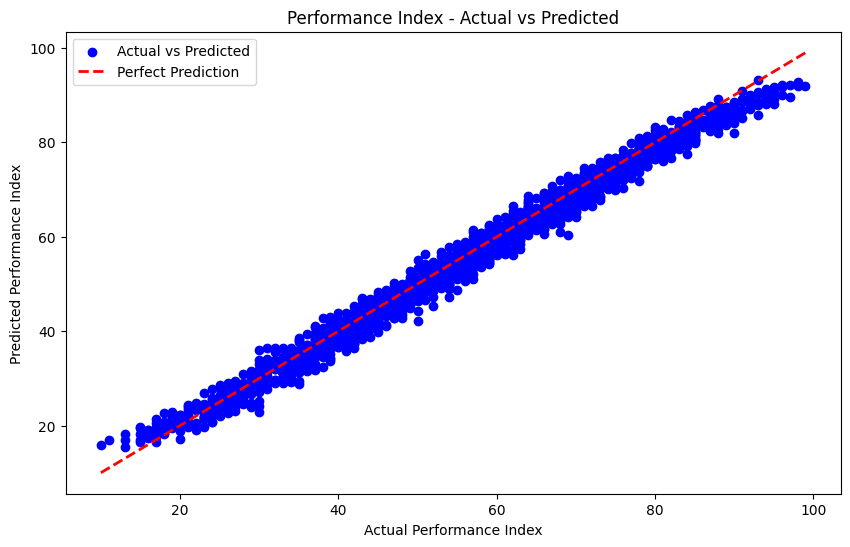

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, ensemble_predictions, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Performance Index')
plt.ylabel('Predicted Performance Index')
plt.title('Performance Index - Actual vs Predicted')
plt.legend()
plt.show()



250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


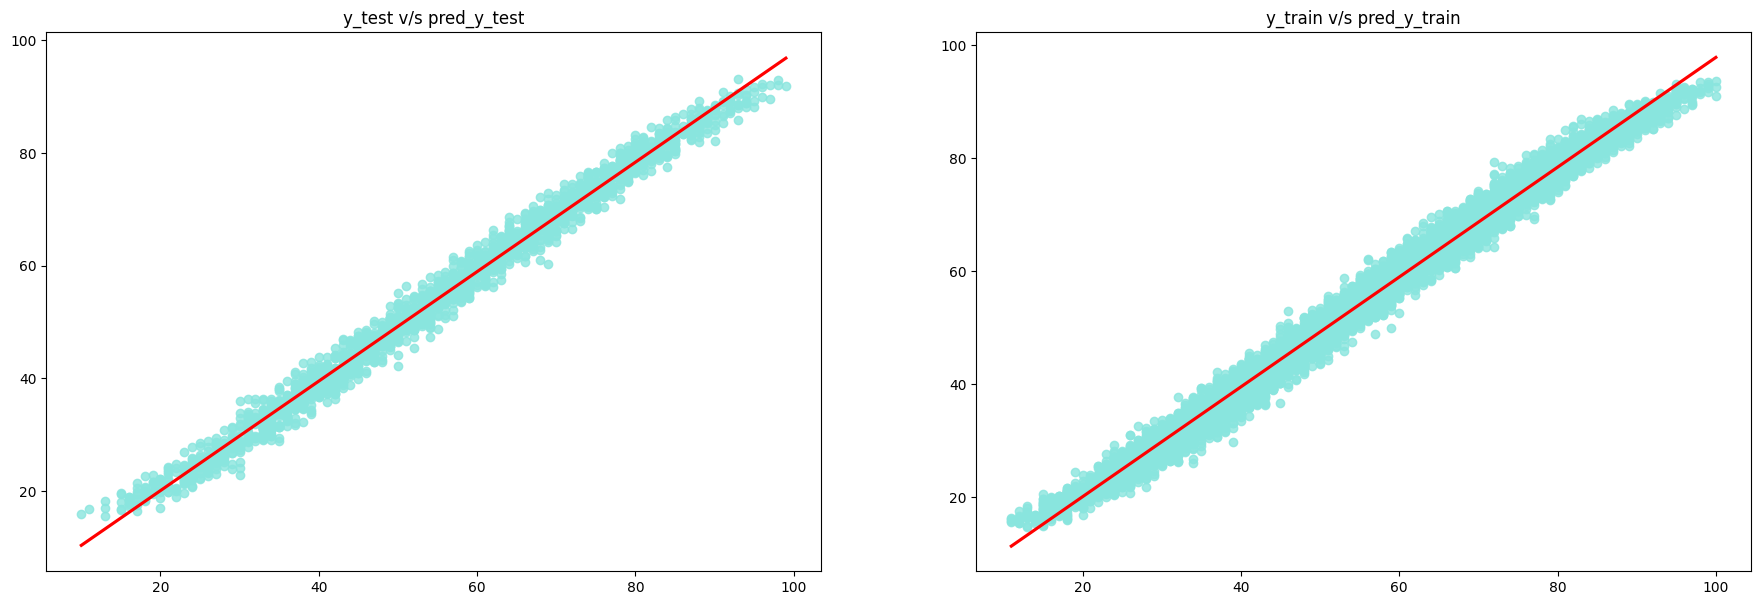

In [13]:
import seaborn as sns
fig,axes=plt.subplots(1,2,figsize=(22,7))
axes[0].set_title('y_test v/s pred_y_test')
sns.regplot(ax=axes[0],x=y_test,y=ensemble_predictions,scatter_kws={'color':'#89E5DE'},line_kws={'color':'r'})
axes[1].set_title('y_train v/s pred_y_train')
sns.regplot(ax=axes[1],x=y_train,y=ensemble_predict(models, x_train),scatter_kws={'color':'#89E5DE'},line_kws={'color':'r'})
plt.show()

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score, mean_absolute_percentage_error
mean_absolute_percentage_error(y_test, ensemble_predictions)
r2Score = r2_score(y_test,ensemble_predictions)
print('r2 Score = ',round(r2Score,4)*100)
mae_score = mean_absolute_error(y_test,ensemble_predictions)
print('Mean Absolute Error = ',round(mae_score,4))
rmse_score = np.sqrt(mean_squared_error(y_test,ensemble_predictions))
print('Root Mean Squared Error = ',round(rmse_score,4))

r2 Score =  98.53
Mean Absolute Error =  1.8611
Root Mean Squared Error =  2.3249


# Estratégia de Ensemble Adotada

A estratégia de ensemble adotada é a média aritmética das previsões dos modelos individuais. Formalmente, isso pode ser descrito da seguinte maneira:

$\widehat{y} = \frac{1}{M} \sum_{m=1}^M \widehat{y}_m$

onde:
- $\widehat{y}$ é a previsão final do ensemble.
- $M$ é o número de modelos no ensemble.
- $\widehat{y}_m$ é a previsão do \(m\)-ésimo modelo.

Essa abordagem melhora a robustez do modelo e reduz o overfitting, pois erros individuais dos modelos tendem a ser suavizados na média.